# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

### Memory Reduction

Due to the huge size of data, analysing the data is very time consuming. As such I started looking for solution online. I found a nice article "[How to handle BigData Files on Low Memory?](https://towardsdatascience.com/how-to-learn-from-bigdata-files-on-low-memory-incremental-learning-d377282d38ff#e618)"

In [ ]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [ ]:
azdias_reduce = reduce_mem_usage(azdias)
customers_reduce = reduce_mem_usage(customers)
mailout_train_reduce = reduce_mem_usage(mailout_train)
mailout_test_reduce = reduce_mem_usage(mailout_test)

In [ ]:
# Save the reduced Memory file
azdias_reduce.to_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers_reduce.to_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')
mailout_train_reduce.to_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
mailout_test_reduce.to_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

### Loading memory reduced data

In [4]:
# Read data with after memory reduction
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')

#Load train and test data after memory reduction
# mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
# mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# Read information on the attributes 
# top-level list of attributes and descriptions, organized by informational category
attributes_des = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
# Detailed mapping of data values for each feature in alphabetical order
attributes_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

### View the data

In [6]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
azdias.describe()

In [ ]:
customers.head()

In [ ]:
customers. describe()

In [7]:
attributes_info.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [8]:
def drop_unnamed_cols(df):
    """
    drop the Unnamed first columns in the data

    """
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

In [9]:
# drop the unnamed columns
drop_unnamed_cols(azdias)
drop_unnamed_cols(customers)
drop_unnamed_cols(attributes_info)
drop_unnamed_cols(attributes_des)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
308,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,EINWOHNER,inhabitants,NaN
310,NaN,GKZ,standardized community-code,NaN
311,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [10]:
# Fill in the null values in the attribute column
attributes_info["Attribute"] = attributes_info["Attribute"].ffill()
attributes_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


### Fix the warning received when loading the data

In [11]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [12]:
customers.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [13]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [14]:
attributes_info[attributes_info["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


##### Look at the extra columnns in customers

In [ ]:
customers['PRODUCT_GROUP'].unique()

In [ ]:
customers['ONLINE_PURCHASE'].describe()

In [ ]:
customers['CUSTOMER_GROUP'].unique()

In [ ]:
# Drop the additional columns
customers.drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'],axis=1,inplace=True)

In [19]:
print(azdias.shape)
print(customers.shape)

(891221, 310)
(191652, 310)


### Looking at the missing values

In [15]:
# Attributes with missing or unknown
unknowns = []
for attribute in attributes_info['Attribute'].unique():
    _ = attributes_info.loc[attributes_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(attributes_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
print(unknowns)

                attribute                                 missing_or_unknown
0                AGER_TYP                                   [-1, 0, 1, 2, 3]
1    ALTERSKATEGORIE_GROB                            [-1,  0, 1, 2, 3, 4, 9]
2                ALTER_HH  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3               ANREDE_KZ                                     [-1,  0, 1, 2]
4     ANZ_HAUSHALTE_AKTIV                                                […]
..                    ...                                                ...
309        WOHNDAUER_2008                [-1,  0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
310              WOHNLAGE                       [-1, 0, 1, 2, 3, 4, 5, 7, 8]
311    WACHSTUMSGEBIET_NB                            [-1,  0, 1, 2, 3, 4, 5]
312        W_KEIT_KIND_HH                         [-1,  0, 1, 2, 3, 4, 5, 6]
313              ZABEOTYP                         [-1,  9, 1, 2, 3, 4, 5, 6]

[314 rows x 2 columns]


In [16]:
# creating a dataframe to get count/percentage of missing values in azdias and customers
azdias_nan=pd.DataFrame(azdias.isna().sum(axis=0)).reset_index()
azdias_nan.columns=['column','azdias_nan']
azdias_nan['azdiaz_nan_percent']=(azdias_nan['azdias_nan']/len(azdias))*100

customers_nan=pd.DataFrame(customers.isna().sum(axis=0)).reset_index()
customers_nan.columns=['column','customers_nan']
customers_nan['customer_nan_percent']=(customers_nan['customers_nan']/len(customers))*100
missing_values=pd.merge(azdias_nan, customers_nan, on='column')
missing_values=missing_values.sort_values(by=['azdias_nan','customers_nan'],ascending=[False,False])
missing_values

,column,azdias_nan,azdiaz_nan_percent,customers_nan,customer_nan_percent
7,ALTER_KIND4,890016,99.864792,191416,99.876860
6,ALTER_KIND3,885051,99.307691,190377,99.334732
5,ALTER_KIND2,861722,96.690047,186552,97.338927
4,ALTER_KIND1,810163,90.904837,179886,93.860748
100,EXTSEL992,654153,73.399639,85283,44.498883
...,...,...,...,...,...
346,SHOPPER_TYP,0,0.000000,0,0.000000
354,VERS_TYP,0,0.000000,0,0.000000
363,ZABEOTYP,0,0.000000,0,0.000000
364,ANREDE_KZ,0,0.000000,0,0.000000


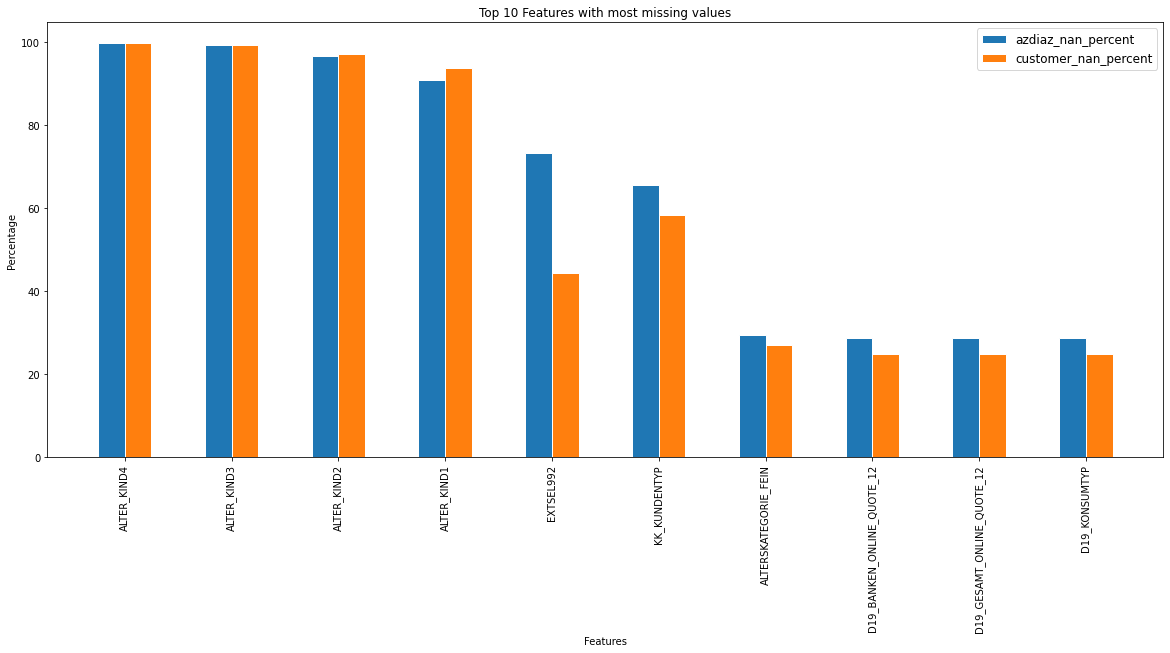

In [17]:
plt.figure(figsize=(20,8))
# set width of bar
barWidth = 0.25
# set height of bar
bars1 = missing_values['azdiaz_nan_percent'][:10]
bars2 = missing_values['customer_nan_percent'][:10]
label=missing_values['column'][:10]
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.bar(r2, bars2, width=barWidth, edgecolor='white')

 
# Add xticks on the middle of the group bars
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], label,rotation=90)
 
# Create legend & Show graphic
plt.title('Top 10 Features with most missing values')
plt.legend(['azdiaz_nan_percent','customer_nan_percent'],prop={'size': 12})
plt.show()

In [18]:
# we will drop the columns with highest missing value
# Only the first variable has more than 60% missing value
drop_cols=list(label[:4])
drop_cols

['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1']

### Check categorical variables

In [19]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns",len(Numeric_columns))
print("Length of categorical columns",len(categorical_col))
print("Categorial columns are",categorical_col)

Length of Numeric columns 360
Length of categorical columns 6
Categorial columns are {'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}


In [20]:
# convert variables to numeric types
azdias[Numeric_columns] = azdias[Numeric_columns].apply(pd.to_numeric)
customers[Numeric_columns] = customers[Numeric_columns].apply(pd.to_numeric)

In [21]:
# Further analysis of categorical columns
category={}
def categorical_check():
    '''
    return a list of unique categorical variables 
    
    '''
    for i in categorical_col:
        category[i]=azdias[i].dropna().unique()
    return category
categorical_check()

{'D19_LETZTER_KAUF_BRANCHE': array(['D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
        'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
        'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
        'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
        'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
        'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
        'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
        'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
        'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
        'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
        'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object),
 'EINGEFUEGT_AM': array(['1992-02-10 00:00:00', '1992-02-12 00:00:00',
        '1997-04-21 00:00:00', ..., '2010-12-02 00:00:00',
        '2005-03-19 00:00:00', '2011-11-18 00:00:00'], dtype=object),
 'OST_WEST_KZ': array(['W', 

- 'EINGEFUEGT_AM' is time data
- 'CAMEO_INTL_2015', 'CAMEO_DEU_2015' and 'CAMEO_DEUG_2015' have XX and X as values

In [22]:
# After further analysis, these variables will be dropped
azdias=azdias.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
customers=customers.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)

azdias=azdias.drop('EINGEFUEGT_AM',axis=1)
customers=customers.drop('EINGEFUEGT_AM',axis=1)

In [23]:
# Replace the X and XX with nan
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)

customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)

#### Further analysis of missing values

In [24]:
# Let's have a closer look at 'Meaning' column in attribute values
attributes_info['Meaning'].value_counts()[:20]

unknown                            232
average                            162
low                                154
high                               154
very high                          142
very low                           139
none                               138
Multibuyer 0-12 months              34
no transaction known                34
Prospects > 24 months               34
Singlebuyer 13-24 months            34
Doublebuyer 0-12 months             34
Singlebuyer 0-12 months             34
Buyer > 24 months                   34
Multi-/Doublebuyer 13-24 months     34
no transactions known               22
highest affinity                    14
low affinity                        14
lowest affinity                     14
very high affinity                  14
Name: Meaning, dtype: int64

we have lots of unknown value in our dataset

In [25]:
# Investigate the unknown values
unknown_attributes_info = attributes_info[attributes_info["Meaning"] == "unknown"]
unknown_attributes_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


The unknown values are not consistent throughtout the dataset
- Some are represented as (-1,0) or (-1,9) or just -1. 
- We need to fix this and make the data consistent.

In [26]:
fix_unknown1=list(set(list(attributes_info[attributes_info['Value']=='-1, 0']['Attribute'])).intersection(set(azdias.columns)))
fix_unknown9=list(set(list(attributes_info[attributes_info['Value']=='-1, 9']['Attribute'])).intersection(set(azdias.columns)))

In [27]:
print(fix_unknown1)

['KKK', 'KBA05_GBZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'HH_EINKOMMEN_SCORE', 'ANREDE_KZ', 'REGIOTYP', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'ALTERSKATEGORIE_GROB']


In [28]:
print(fix_unknown9)

['KBA05_ALTER1', 'KBA05_HERST2', 'SEMIO_FAM', 'KBA05_KRSAQUOT', 'KBA05_MOD1', 'KBA05_HERST1', 'SEMIO_MAT', 'SEMIO_TRADV', 'KBA05_AUTOQUOT', 'KBA05_MAXHERST', 'KBA05_DIESEL', 'KBA05_KRSOBER', 'KBA05_ZUL3', 'SEMIO_KAEM', 'SEMIO_VERT', 'KBA05_CCM3', 'KBA05_ALTER4', 'SEMIO_REL', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_HERST4', 'KBA05_ZUL4', 'KBA05_MAXAH', 'KBA05_KRSHERST3', 'KBA05_KRSHERST1', 'SEMIO_PFLICHT', 'KBA05_KRSVAN', 'KBA05_MOTRAD', 'KBA05_HERST5', 'KBA05_ANHANG', 'KBA05_ZUL1', 'KBA05_CCM2', 'SEMIO_RAT', 'KBA05_VORB0', 'KBA05_ALTER2', 'KBA05_SEG4', 'KBA05_MAXBJ', 'KBA05_MOD8', 'KBA05_KRSKLEIN', 'KBA05_SEG9', 'SEMIO_ERL', 'SEMIO_KRIT', 'KBA05_SEG5', 'KBA05_KW2', 'KBA05_SEG7', 'KBA05_MAXSEG', 'KBA05_HERSTTEMP', 'KBA05_ALTER3', 'KBA05_KRSHERST2', 'KBA05_KW1', 'KBA05_SEG10', 'KBA05_MOD2', 'KBA05_SEG2', 'KBA05_SEG8', 'KBA05_VORB1', 'KBA05_MOTOR', 'KBA05_KRSZUL', 'SEMIO_SOZ', 'RELAT_AB', 'KBA05_MAXVORB', 'KBA05_FRAU', 'KBA05_MOD4', 'SEMIO_DOM', 'KBA05_HERST3', 'KBA05_MOD3', 'KBA05_SEG6', 'SEMI

In [29]:
azdias[fix_unknown1]=azdias[fix_unknown1].replace(0,-1)
azdias[fix_unknown9]=azdias[fix_unknown9].replace(9,-1)

In [30]:
customers[fix_unknown1]=customers[fix_unknown1].replace(0,-1)
customers[fix_unknown9]=customers[fix_unknown9].replace(9,-1)

#### Missing value in Columns

In [31]:
# Remove rows with most missing values
azdias=azdias[azdias.isnull().sum(axis=1)<=20]

customers=customers[customers.isnull().sum(axis=1)<=20]

In [33]:
# Dropping columns with most missing values
azdias=azdias.drop(drop_cols,axis=1)

customers=customers.drop(drop_cols,axis=1)

### Drop Correlated features above threshold of 75%


In [ ]:
# find correlation matrix and drop variables with greater than 75% correlation  
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .75)]

In [ ]:
azdias.drop(drop_columns,axis=1,inplace=True)

In [ ]:
customers.drop(drop_columns,axis=1,inplace=True)

### forward fill Nan Values 
Find and relace nan values witht the mode

In [35]:
print(azdias.isna().sum().sum())
print(customers.isna().sum().sum())

2664489
131091


Text(0.5, 0, 'Percent of missing values')

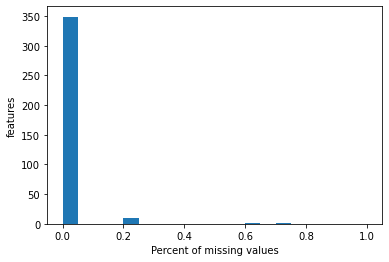

In [36]:
#looking for nans in columns
column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('features')
plt.xlabel('Percent of missing values')

In [37]:
azdias=azdias.fillna(azdias.mode().iloc[0])
customers=customers.fillna(customers.mode().iloc[0])

In [38]:
print(azdias.isna().sum().sum())
print(customers.isna().sum().sum())

0
0


In [39]:
print(azdias.shape)
print(customers.shape)

(745305, 360)
(132095, 363)


### One-hot encoding categorical variables

In [40]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in azdias",len(Numeric_columns))
print("Length of categorical columns in azdias",len(categorical_col))
print("Categorial columns in azdias are",categorical_col)

Length of Numeric columns in azdias 358
Length of categorical columns in azdias 2
Categorial columns in azdias are {'OST_WEST_KZ', 'CAMEO_DEU_2015'}


In [42]:
# Getting all numeric columns and categorical columns
Numeric_columns=customers.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(customers.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in customers",len(Numeric_columns))
print("Length of categorical columns in customers",len(categorical_col))
print("Categorial columns in customers are",categorical_col)

Length of Numeric columns in customers 359
Length of categorical columns in customers 4
Categorial columns in customers are {'PRODUCT_GROUP', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CUSTOMER_GROUP'}


In [43]:
azdias=pd.get_dummies(azdias)
customers=pd.get_dummies(customers)

### Standardize the data

In [45]:
scaler = StandardScaler()
azdias[azdias.columns] = scaler.fit_transform(azdias)
customers[customers.columns] = scaler.fit_transform(customers)

In [46]:
print(azdias.shape)
print(customers.shape)

(745305, 405)
(132095, 411)


### Save the cleaned data

In [ ]:
azdias.to_csv('azdias_clean.csv')
customers.to_csv('customers_clean.csv')


### Complete data preprocessing

In [51]:
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')
def drop_unnamed_cols(df):
    """
    drop the Unnamed columns in the data

    """
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

fix_unknown1 = ['KKK', 'KBA05_GBZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'HH_EINKOMMEN_SCORE', 'ANREDE_KZ', 'REGIOTYP', 
                'WOHNDAUER_2008', 'W_KEIT_KIND_HH', 'KBA05_BAUMAX', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'ALTERSKATEGORIE_GROB']

fix_unknown9 =['KBA05_ALTER1', 'KBA05_HERST2', 'SEMIO_FAM', 'KBA05_KRSAQUOT', 'KBA05_MOD1', 'KBA05_HERST1', 'SEMIO_MAT', 
                'SEMIO_TRADV', 'KBA05_AUTOQUOT', 'KBA05_MAXHERST', 'KBA05_DIESEL', 'KBA05_KRSOBER', 'KBA05_ZUL3', 'SEMIO_KAEM',
               'SEMIO_VERT', 'KBA05_CCM3', 'KBA05_ALTER4', 'SEMIO_REL', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_HERST4', 
               'KBA05_ZUL4', 'KBA05_MAXAH', 'KBA05_KRSHERST3', 'KBA05_KRSHERST1', 'SEMIO_PFLICHT', 'KBA05_KRSVAN', 
               'KBA05_MOTRAD', 'KBA05_HERST5', 'KBA05_ANHANG', 'KBA05_ZUL1', 'KBA05_CCM2', 'SEMIO_RAT', 'KBA05_VORB0', 
               'KBA05_ALTER2', 'KBA05_SEG4', 'KBA05_MAXBJ', 'KBA05_MOD8', 'KBA05_KRSKLEIN', 'KBA05_SEG9', 'SEMIO_ERL', 
               'SEMIO_KRIT', 'KBA05_SEG5', 'KBA05_KW2', 'KBA05_SEG7', 'KBA05_MAXSEG', 'KBA05_HERSTTEMP', 'KBA05_ALTER3', 
               'KBA05_KRSHERST2', 'KBA05_KW1', 'KBA05_SEG10', 'KBA05_MOD2', 'KBA05_SEG2', 'KBA05_SEG8', 'KBA05_VORB1', 
               'KBA05_MOTOR', 'KBA05_KRSZUL', 'SEMIO_SOZ', 'RELAT_AB', 'KBA05_MAXVORB', 'KBA05_FRAU', 'KBA05_MOD4', 
               'SEMIO_DOM', 'KBA05_HERST3', 'KBA05_MOD3', 'KBA05_SEG6', 'SEMIO_LUST', 'KBA05_ZUL2', 'KBA05_CCM1', 
               'KBA05_MODTEMP', 'ZABEOTYP', 'KBA05_SEG1', 'SEMIO_KULT', 'KBA05_CCM4', 'KBA05_VORB2']

from sklearn.preprocessing import StandardScaler
def data_cleaning(df,name=None):
    '''
    Function take data as uinput and pre_processed the data 
    Output is cleaned data
    
    '''
    drop_unnamed_cols(df)
    print("Shape before",df.shape)
    if name=='customers':
        df=df.drop(['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'],axis=1)
    
    if name=='azdias':
        df=df[df.isnull().sum(axis=1)<=20].reset_index(drop=True)
        
    # finding numeric and categorical columns
    Numeric_columns=df.select_dtypes(include=np.number).columns.tolist()
    categorical_col=set(df.columns).difference(set(Numeric_columns))
    
    # numeric cols to numeric
    print(categorical_col)
    df[Numeric_columns]=df[Numeric_columns].apply(pd.to_numeric)
    
    # drop columns to avoid lot of columns
    df=df.drop('D19_LETZTER_KAUF_BRANCHE',axis=1)
    df=df.drop('EINGEFUEGT_AM',axis=1)
    df=df.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1'],axis=1)

    
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015','CAMEO_DEU_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]=df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric)
    #

    df[fix_unknown1]=df[fix_unknown1].replace(0,-1)
    df[fix_unknown9]=df[fix_unknown9].replace(9,-1)
    
    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .75)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)
    
    # fill nan with mode
    df=df.fillna(df.mode().iloc[0])
    print("Number of nan Values",df.isna().sum().sum())
    df=pd.get_dummies(df)
    
    # Standardised data
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df)
    print("shape after",df.shape)
    df = df.set_index('LNR')
    return df

azdias_clean=data_cleaning(azdias,'azdias')
customers_clean=data_cleaning(customers,'customers')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Shape before (891221, 366)
{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}
shape after corr (744305, 279)
Number of nan Values 0
shape after (744305, 324)
Shape before (191652, 369)
{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}
shape after corr (191652, 276)
Number of nan Values 0
shape after (191652, 321)


#### Fix columns difference

In [55]:
azdias_clean.shape

(744305, 323)

In [56]:
customers_clean.shape

(191652, 320)

In [60]:
# Difference in columns
print(set(list(customers_clean.columns)) - set(list(azdias_clean.columns)))

{'GEBAEUDETYP_RASTER', 'D19_KONSUMTYP', 'KBA13_BAUMAX', 'KONSUMZELLE', 'CJT_TYP_3', 'ANREDE_KZ', 'WOHNDAUER_2008', 'VK_DHT4A'}


In [59]:
# Difference in columns
print(set(list(azdias_clean.columns)) - set(list(customers_clean.columns)))

{'SEMIO_REL', 'FINANZ_ANLEGER', 'KBA13_HHZ', 'KOMBIALTER', 'KBA13_BJ_2000', 'CJT_TYP_4', 'SEMIO_KAEM', 'SEMIO_KRIT', 'FINANZ_UNAUFFAELLIGER', 'NATIONALITAET_KZ', 'VERS_TYP'}


In [62]:
# Drop columns
customers_clean.drop(columns=['GEBAEUDETYP_RASTER', 'D19_KONSUMTYP', 'KBA13_BAUMAX', 'KONSUMZELLE', 'CJT_TYP_3', 'ANREDE_KZ',
                              'WOHNDAUER_2008', 'VK_DHT4A'], inplace=True)

azdias_clean.drop(columns=['SEMIO_REL', 'FINANZ_ANLEGER', 'KBA13_HHZ', 'KOMBIALTER', 'KBA13_BJ_2000', 'CJT_TYP_4', 'SEMIO_KAEM',
                           'SEMIO_KRIT', 'FINANZ_UNAUFFAELLIGER', 'NATIONALITAET_KZ', 'VERS_TYP'], inplace=True)

In [63]:
print(azdias_clean.shape)
print(customers_clean.shape)


(744305, 312)
(191652, 312)


#### Save clean data

In [65]:
# Save cleaned data
azdias_clean.to_csv('azdias_cleaned.csv', index=False)
customers_clean.to_csv('customers_cleaned.csv', index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Load the cleaned data

In [66]:
azdias = pd.read_csv('azdias_cleaned.csv')

In [67]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-0.573138,1.249922,-1.419539,1.560724,0.158256,-0.128594,-0.297023,0.232945,-0.060494,-0.189851,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
1,-0.573138,1.249922,0.808202,0.675260,0.094457,-0.128594,-0.297023,-0.627017,-0.060494,-0.189851,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
2,1.857451,-0.942389,0.284028,-0.210205,-0.479738,-0.128594,-0.297023,-1.486979,-0.060494,-1.195240,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
3,-0.573138,-0.942389,1.201333,0.011161,-0.352140,-0.128594,-0.297023,1.952869,-0.060494,0.815537,...,-0.211823,-0.205615,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892
4,2.667648,-0.942389,-0.109103,-0.874304,-0.224541,-0.128594,-0.297023,-0.627017,-0.060494,-1.195240,...,-0.211823,4.863456,-0.153395,-0.166375,-0.19337,-0.183414,-0.196412,-0.087037,-0.519892,0.519892


In [68]:
customers = pd.read_csv('customers_cleaned.csv')

In [69]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1.189681,-0.325074,0.192466,-0.068433,-0.235979,-0.105218,-0.238379,-0.166805,-0.116283,-2.144783,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
1,-0.966005,4.271391,0.329163,-0.068433,-0.235979,-0.105218,-0.238379,0.656067,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
2,-0.966005,-0.325074,-0.354319,-2.897572,-0.235979,-0.105218,-0.238379,-0.989677,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
3,0.471119,-0.325074,-0.080926,-0.634261,-0.316443,-0.105218,-0.238379,-1.812549,-0.116283,-2.144783,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816
4,-0.966005,-0.325074,1.559431,1.063223,0.246806,-0.105218,-0.238379,1.478939,-0.116283,0.147901,...,-0.142037,-0.121786,-0.10791,-0.073256,-0.069338,-0.071949,-0.10157,-0.089055,-0.250816,0.250816


In [70]:
print(azdias.shape)
print(customers.shape)

(744305, 312)
(191652, 312)


### Dimensionality Reduction - PCA

In [71]:
pca=PCA()
pca.fit(azdias)

PCA()

In [72]:
pca.explained_variance_ratio_[:6]

array([0.06315867, 0.04419733, 0.03180012, 0.02622891, 0.02521861,
       0.02261799])

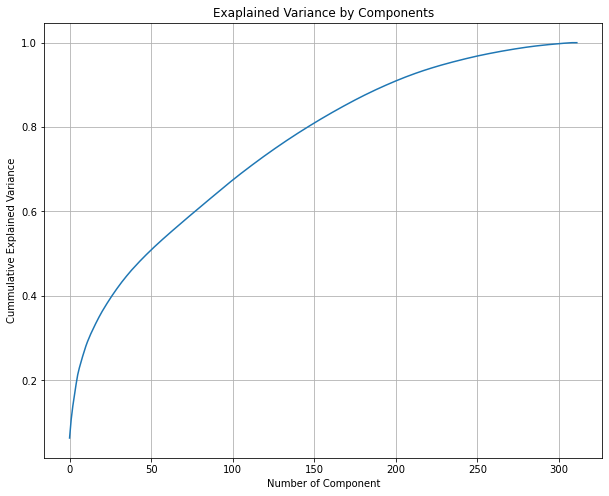

In [73]:
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("Exaplained Variance by Components")
plt.xlabel("Number of Component")
plt.ylabel("Cummulative Explained Variance")
plt.grid(True)
plt.show()

We want to preserve total  variability of more than 80%
- as such we are going to keep the number of components to 200 for around 90% of Cummulative variance

In [74]:
def perform_pca(df,n=200):
    '''
    Returns transformed data with PCA

    '''
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [75]:
pca_azdias = perform_pca(azdias)
pca_customers = perform_pca(customers)

0.9060338413292465
0.9070585806576955


In [76]:
# shape of reduced components
print(pca_azdias.shape)
print(pca_customers.shape)

(744305, 200)
(191652, 200)


### K-Means Clustering

Determine the number of clusters

In [78]:
pca_azdias_sample=pca_azdias.sample(20000)

In [79]:
# Determine the Within Cluster Sum of Squares (WCSS) for each solution
wcss=[]
score=[]
for i in range(1,21):
    #print(i)
    kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    model=kmeans_pca.fit(pca_azdias_sample)
    wcss.append(model.inertia_)

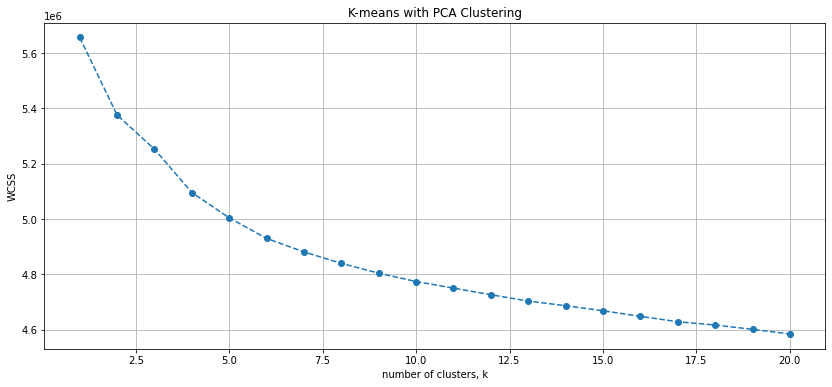

In [86]:
plt.figure(figsize=(14,6))
plt.plot(range(1,21),wcss,marker='o',linestyle='--')
plt.xlabel('number of clusters, k')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.grid(True)
plt.show()

According to the Elbow method, look like cluster 3-6

In [104]:
kmeans = KMeans(3)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

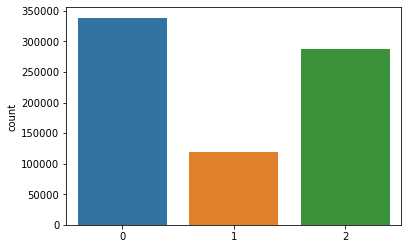

In [105]:
sns.countplot(prediction_azdias)

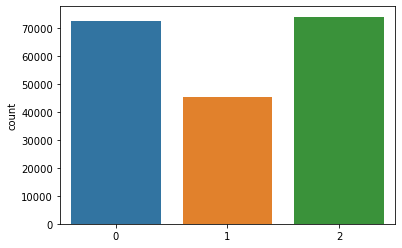

In [106]:
sns.countplot(prediction_customers)

In [91]:
kmeans = KMeans(4)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

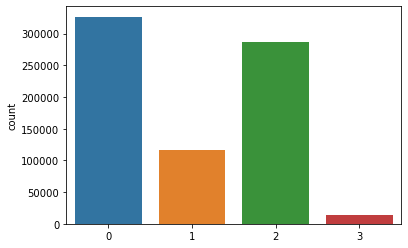

In [92]:
sns.countplot(prediction_azdias)

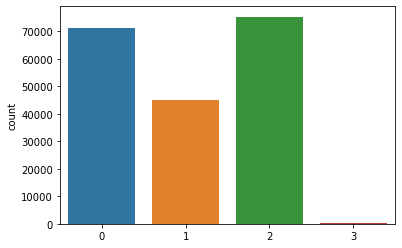

In [93]:
sns.countplot(prediction_customers)

In [94]:
kmeans = KMeans(5)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

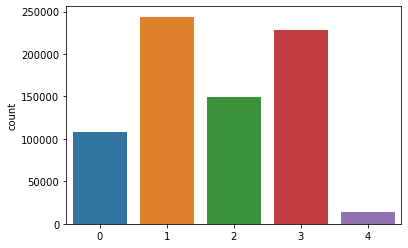

In [95]:
sns.countplot(prediction_azdias)

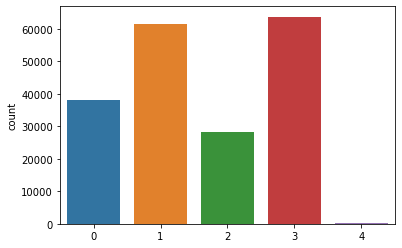

In [96]:
sns.countplot(prediction_customers)

In [97]:
kmeans = KMeans(6)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

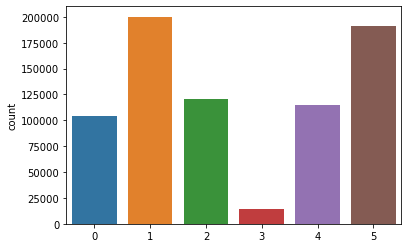

In [98]:
sns.countplot(prediction_azdias)

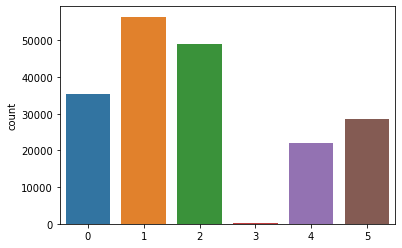

In [99]:
sns.countplot(prediction_customers)

In [69]:
kmeans = KMeans(7)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

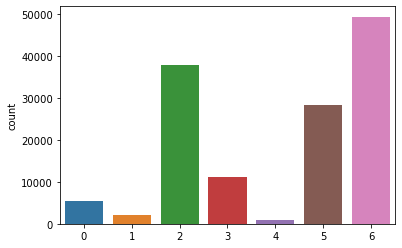

In [70]:
sns.countplot(prediction_customers)

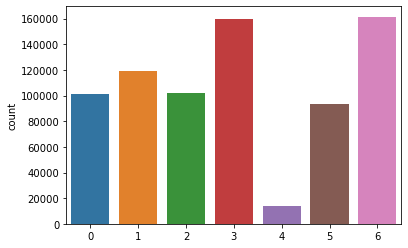

In [71]:
sns.countplot(prediction_azdias)

In [75]:
kmeans = KMeans(6)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

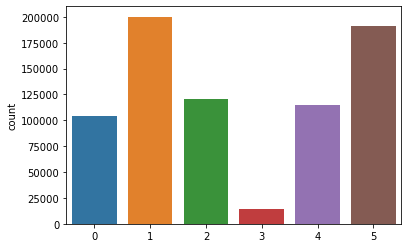

In [100]:
sns.countplot(prediction_azdias)

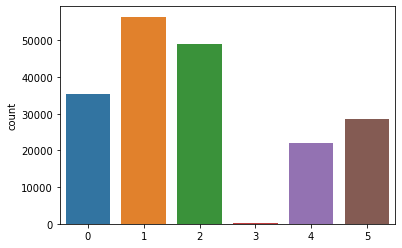

In [101]:
sns.countplot(prediction_customers)

#### k-means with k =3, 
- 3 clusters seems to be better than the other

In [112]:
kmeans = KMeans(3)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

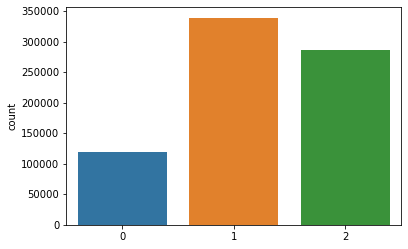

In [113]:
sns.countplot(prediction_azdias)

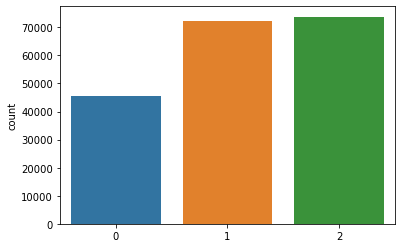

In [114]:
sns.countplot(prediction_customers)

In [170]:
from yellowbrick.cluster import KElbowVisualizer

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

In [121]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [140]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [141]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']
df_mailout_train  = data_cleaning(X)
# pca_X_df = perform_pca(df_mailout_train)
# prediction_cluster = model.predict(pca_X_df)

# df_mailout_train['Cluster']=prediction_cluster

Shape before (42962, 366)
{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}
shape after corr (42962, 276)
Number of nan Values 0
shape after (42962, 321)


##### Split Data 

In [142]:
X_train,X_test,y_train,y_test = train_test_split(df_mailout_train,y,random_state=42,test_size=0.3)

In [143]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=42,test_size=0.3)

In [144]:
model_xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=0.7, eval_metric='auc', gamma=1.0,
                        learning_rate=0.01, max_delta_step=0, max_depth=7,
                        min_child_weight=1, missing=None, n_estimators=250, n_jobs=-1,
                        nthread=None, objective='binary:logistic', random_state=42,
                        reg_alpha=1e-07, reg_lambda=1, scale_pos_weight=1, seed=None,
                        silent=1, subsample=0.5)

In [145]:
model_xg.fit(X_train,y_train)

[21:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
             gamma=1.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None,
             monotone_constraints='()', n_estimators=250, n_jobs=-1, nthread=4,
             num_parallel_tree=1, objective='binary:logistic', random_state=42,
             reg_alpha=1e-07, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, ...)

In [146]:
from sklearn.metrics import roc_auc_score
pred_train = model_xg.predict(X_train)
pred_test = model_xg.predict(X_test)
pred_val = model_xg.predict(X_val)

In [147]:
roc_auc_score(y_train,pred_train)

0.9084999443701693

In [148]:
roc_auc_score(y_test,pred_test)

0.7758407076409347

In [149]:
roc_auc_score(y_val,pred_val)

0.7770589970636395

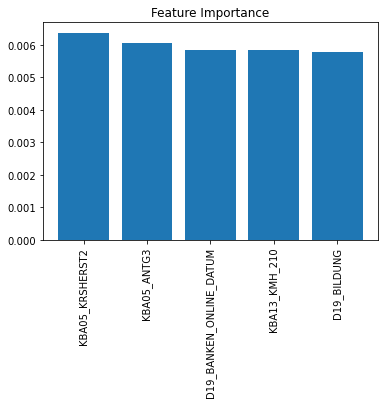

In [150]:
# Calculate feature importances
importances = model_xg.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:5]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices][:5]


# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(5), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(5) ,names, rotation=90)

# Show plot
plt.show()

In [166]:
from yellowbrick.model_selection import FeatureImportances

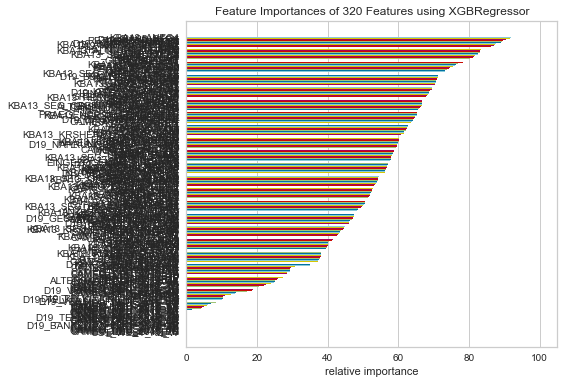

In [169]:
viz = FeatureImportances(model_xg)
viz.fit(df_mailout_train, y)
viz.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [151]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [152]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [153]:
mailout_test_clean = data_cleaning(mailout_test)


Shape before (42833, 366)
{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'}
shape after corr (42833, 276)
Number of nan Values 0
shape after (42833, 321)


In [154]:
# Differences in columns
set(list(df_mailout_train.columns)) - set(list(mailout_test_clean.columns))

set()

In [155]:
# Differences in columns
set(list(mailout_test_clean.columns)) - set(list(df_mailout_train.columns))

set()

In [156]:
testpred = model_xg.predict(mailout_test_clean)

In [159]:
# prediction_for_kaggle = reg_model.predict(mailout_test_clean)
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=testpred)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)


In [160]:
df_kaggle.to_csv('submission1.csv')